# Convex Optimization for Machine Learning & Computer Vision
## Week 0 Programming Exercise - Intro. to Sparse Matrices

| Name  | Matriculation Number  | E-mail  |
| :------- | :----------------------- | :--------- |
| Akbar, Uzair   | 03697290 | [uzair.akbar@tum.de](mailto:uzair.akbar@tum.de) |

In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from PIL import Image

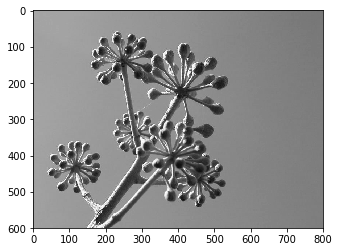

In [2]:
# read the image from input file as grayscale and transform to numpy array
f = np.array(Image.open('Vegetation-028.jpg').convert('L'), dtype=np.float64)
f /= 255.0
m, n = f.shape
plt.figure('Grayscale')
plt.imshow(f, cmap='gray')
plt.show()

### Exercise 1
$$
\begin{align*}
\mathbf{\tilde{D}_x} = \begin{bmatrix}-1 & & & 0 & 0 \\
+1 & \ddots & & & \vdots \\
& \ddots & -1 & & \\
0 & & +1 & -1 & 0 \end{bmatrix}
\end{align*} \;\in \mathbb{R}^{n \times n}
$$

$$
\begin{align*}
\mathbf{\tilde{D}_y} = \begin{bmatrix}-1 & +1 & &  0 \\
& \ddots & \ddots &  \\
& &  -1 & +1 \\
0  & \dots & 0 & 0 \end{bmatrix}
\end{align*} \;\in \mathbb{R}^{m \times m}
$$

### Exercise 2

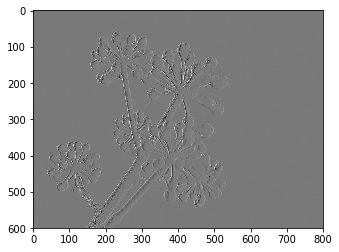

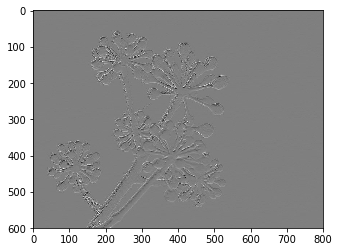

In [3]:
# Put the values of e along the lower diagonal (identified as -1) and
# Put the values of -e along the actual diagonal (0)
# Dx_tilde is of dimension nxn
# Take care of the Boundary conditions: Neumann boundary conditions
e_1 = np.ones(n)
e0 = -np.ones(n)
e0[-1] = 0
Dx_tilde = sparse.spdiags([e_1, e0], [-1, 0], n, n)  # dia_matrix
# compute the x-derivative f_x (Output f_x is a matrix)
f_x = f * Dx_tilde

# Put the values of -e along the actual diagonal (0) and
# Put the values of e along the upper diagonal (1)
# Dy_tilde is of dimension mxm
# Take care of the Boundary conditions.
e1 = np.ones(m)
e0 = -np.ones(m)
e0[-1] = 0
Dy_tilde = sparse.spdiags([e0, e1], [0, 1], m, m)  # dia_matrix
# compute the y-derivative f_y (Output f_y is a matrix)
f_y = Dy_tilde * f

# %%
# Visualize f_x and f_y
plt.figure('Dx')
plt.imshow(f_x, cmap='gray')
plt.figure('Dy')
plt.imshow(f_y, cmap='gray')
plt.show()

### Exercise 3

$\mathbf{D_x} = \mathbf{\tilde{D}_x}^T \otimes \mathbf{I}_{m} \;\;\in \mathbb{R}^{mn\times mn}$

$\mathbf{D_y} = \mathbf{I}_{n} \otimes \mathbf{\tilde{D}_y} \;\;\;\;\in \mathbb{R}^{mn\times mn}$

In [4]:
# Apply the formula from the exercise sheet.
Dx = sparse.kron(Dx_tilde.T, sparse.eye(m))  # coo_matrix
Dy = sparse.kron(sparse.eye(n), Dy_tilde)  # coo_matrix

# vectorize the image and the gradients by stacking the columns.
# note that due to the storage order of numpy, transpose is needed.
vec_f = f.T.flatten()
vec_f_x = f_x.T.flatten()
vec_f_y = f_y.T.flatten()
# According to the formula from the exercise sheet Dx*vec(f) should be the
# same as vec(f_x).
diff = np.linalg.norm(Dx * vec_f - vec_f_x)
# num2str changes a "number" type into string.
print('Difference should be zero: {}'.format(diff))

# Same holds for the y-derivative f_y
diff = np.linalg.norm(Dy * vec_f - vec_f_y)
print('Difference should be zero: {}'.format(diff))

Difference should be zero: 0.0
Difference should be zero: 0.0


### Exercise 4

$\nabla_c = \begin{pmatrix} 
\mathbf{I}_3 \otimes \mathbf{D}_x \\
\mathbf{I}_3 \otimes \mathbf{D}_y
\end{pmatrix} \;\;\in \mathbb{R}^{6mn \times 3mn}$

In [5]:
# Assemble a color gradient using the kronecker product and concatenation, and
# the matrices Dx and Dy.
Nabla_c = sparse.vstack([sparse.kron(sparse.eye(3), Dx),
                         sparse.kron(sparse.eye(3), Dy)])

### Exercise 5

In [6]:
# Read the image from the file
f1_c = np.array(Image.open('Vegetation-028.jpg'), dtype=np.float64)

# Compute the color gradient by applying Nabla_c to the vectorized color
# image. The result is a vectorized 2 x 3 x n x m Tensor containing the
# 2 x 3 Color gradients for each pixel.
Nabla_c_f1_vec = Nabla_c * f1_c.T.flatten()

# to compute color TV we at each pixel need to compute the Frobenius
# norm of the 2 x 3 Color gradients and sum the values.
# Since the Frobenius norm of a matrix is equal to the 2-norm of the
# vectorized matrix we reshape Nabla_c_f1 to a 6 x m*n matrix...
Nabla_c_f1_mat = np.reshape(Nabla_c_f1_vec, (6, m*n))

# ...and for each column (corresponding to a pixel) compute the 2-norm of the
# column and...
sq1 = np.sqrt(np.sum(Nabla_c_f1_mat ** 2, 0))
# ...finally sum over all rows.
TV_c_f1 = np.sum(sq1)
print('TV of Vegetation-028.jpg is {}'.format(TV_c_f1/(m*n)))

# Same for the other image.
f2_c = np.array(Image.open('Vegetation-043.jpg'), dtype=np.float64)
Nabla_c_f2 = Nabla_c * f2_c.T.flatten()
sq2 = np.sqrt(np.sum(np.reshape(Nabla_c_f2, (6, m*n)) ** 2, 0))
TV_c_f2 = np.sum(sq2)
print('TV of Vegetation-043.jpg is {}'.format(TV_c_f2/(m*n)))

# Same for a constant image.
f3_c = 255 * np.ones((m, n, 3))
Nabla_c_f3 = Nabla_c * f3_c.T.flatten()
sq3 = np.sqrt(np.sum(np.reshape(Nabla_c_f3, (6, m*n)) ** 2, 0))
TV_c_f3 = np.sum(sq3)
print('TV of a constant image should be zero {}'.format(TV_c_f3/(m*n)))


TV of Vegetation-028.jpg is 12.807514890560677
TV of Vegetation-043.jpg is 84.64351808245716
TV of a constant image should be zero 0.0


***